# Objective - To predict the 'price' of used cars given its features

### This problem statement is taken from this Machine Learning Hackathon (Regression Modelling)

### Evauation Metric - (RMSLE) - Root Mean Squared Log Error
#### https://www.machinehack.com/course/predicting-the-costs-of-used-cars-hackathon-by-imarticus/Evaluation

##### Understanding RMSLE - https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a

##### Code References used from - www.appliedaicourse.com

# Table of Contents

[1. Import Libraries](#section1)<br>
[2. Load Data](#section2)<br>
[3. Exploratory Data Analysis](#section3)<br>
[4. Missing Values Imputation](#section4)<br>
[5. Primary Conclusions and Inferences](#section5)<br>

### Other .ipynb notebook references

[Outlier Handling](#section100)<br>

# <a id = 'section1'>1. Import Libraries</a>

In [217]:
#general purpose libraries...
import os
#print(os.getcwd())
import warnings
warnings.filterwarnings('ignore')
import pickle
from prettytable import PrettyTable
import math
import re
from tqdm import tqdm,tqdm_notebook


#data analysis libraries...
import pandas as pd
import numpy as np 
import scipy
from scipy import sparse
from scipy.sparse import hstack



#visualization libraries...
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#Modelling Libraries....
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,mean_squared_error,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression,SGDRegressor
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from xgboost import XGBClassifier


#nlp libraries...
from collections import Counter 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


#Deep Learning Libraries..
#from keras.preprocessing.text import Tokenizer                    
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras import layers
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers.embeddings import Embedding
#from keras.preprocessing import sequence


#Multicollinearity 
from scipy import stats
import scipy.stats as ss
import itertools

#### Defining RMSE 

In [2]:
'''This function takes in actual and predicted values and returns RMSE'''

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error((y_true), (y_pred)))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

#### Defining RMSLE 

In [3]:
#reference - https://stackoverflow.com/questions/46202223/root-mean-log-squared-error-issue-with-scitkit-learn-ensemble-gradientboostingre

In [3]:
'''This function takes in actual,predicted values and computes RMSLE value'''

def rmsle_score(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

# <a id = 'section2'>2. Load Data</a>

In [4]:
df = pd.read_csv('Data_Train_csv.csv',encoding = 'cp1252')

print("shape of data is ",df.shape,'\n\n')
print(df.dtypes)

shape of data is  (6019, 13) 


Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object


In [5]:
df.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50


# <a id = 'section3'>3. Exploratory Data Analysis</a>

## 3.1 EDA for 'Price' Distribution

Check Missing Values in Price Column  0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F76C9A6B70>]],
      dtype=object)

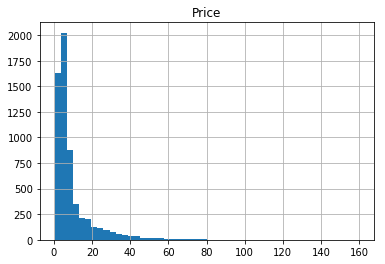

In [6]:
print("Check Missing Values in Price Column ",df['Price'].isnull().sum())
df.hist(column='Price', bins=50)

##### Plot summary - This distribution looks quite skewed, let's perform a log() transform and observe...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F773C6B6D8>]],
      dtype=object)

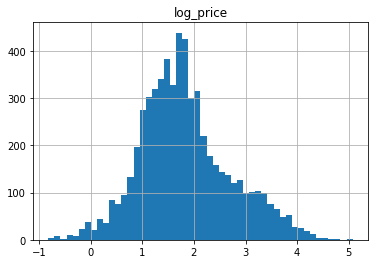

In [7]:
df['log_price'] = np.log(df['Price']) 
df.hist(column='log_price', bins=50)

##### Plot summary - Looks like this is a Log Normally Distributed Target Feature- (Great !!) . Atleast for visualization purposes, we shall use log(price) as target variable

### Check Predictive power of price - 'mean' and 'median' models

In [8]:
df_train, df_test = train_test_split(df, test_size=0.25)
print(df_train.shape)
print(df_test.shape)

(4514, 14)
(1505, 14)


#### Baseline - Mean Model 

In [9]:
# Takes the mean of the training data and uses that to predict on test

print('RMSE for Mean(Price) is', rmse_score(df_test.Price.values,[np.mean(df_train.Price.values)]*len(df_test)))
print('RMSLE for Mean(Price) is', rmsle_score(df_test.Price.values,[np.mean(df_train.Price.values)]*len(df_test)))

RMSE for Mean(Price) is 10.366387924304702
RMSLE for Mean(Price) is 0.8083442132460384


#### Baseline - Median Model 

In [10]:
# Takes the Median of the training data and uses that to predict on test

print('RMSE for Median(Price) is', rmse_score(df_test.Price.values,[np.median(df_train.Price.values)]*len(df_test)))
print('RMSLE for Median(Price) is', rmsle_score(df_test.Price.values,[np.median(df_train.Price.values)]*len(df_test)))

RMSE for Median(Price) is 10.928735580813951
RMSLE for Median(Price) is 0.7352967036457551


## 3.2 EDA for 'Location'

In [11]:
df_loc_eda = pd.DataFrame(df.groupby('Location').size().reset_index())
df_loc_eda.columns = ['location','count']
df_loc_eda

,location,count
0,Ahmedabad,224
1,Bangalore,358
2,Chennai,494
3,Coimbatore,636
4,Delhi,554
5,Hyderabad,742
6,Jaipur,413
7,Kochi,651
8,Kolkata,535
9,Mumbai,790


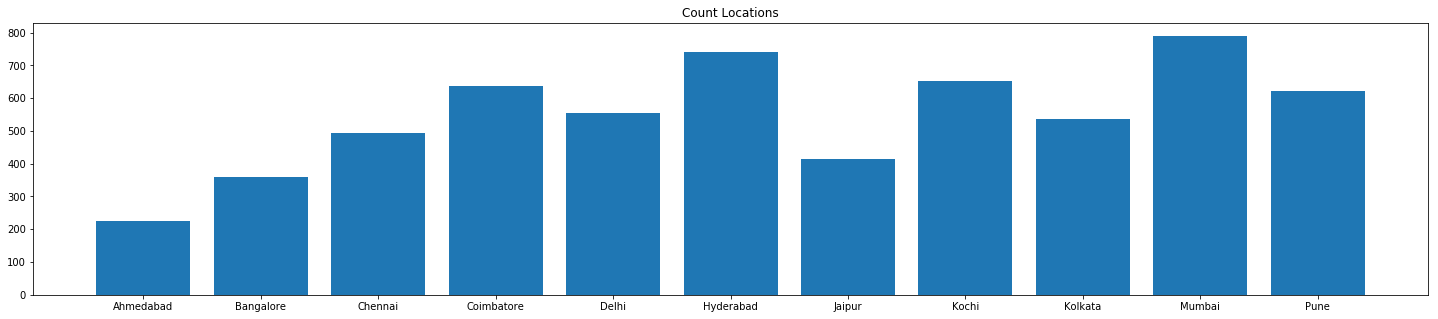

In [12]:
plt.figure(figsize = (25,5))
plt.bar(df_loc_eda['location'],df_loc_eda['count'])
plt.title('Count Locations')
plt.show()

##### Plot summary - All major cities have significant contribution in the resale of used cars

Check Missing Values in Location Column  0


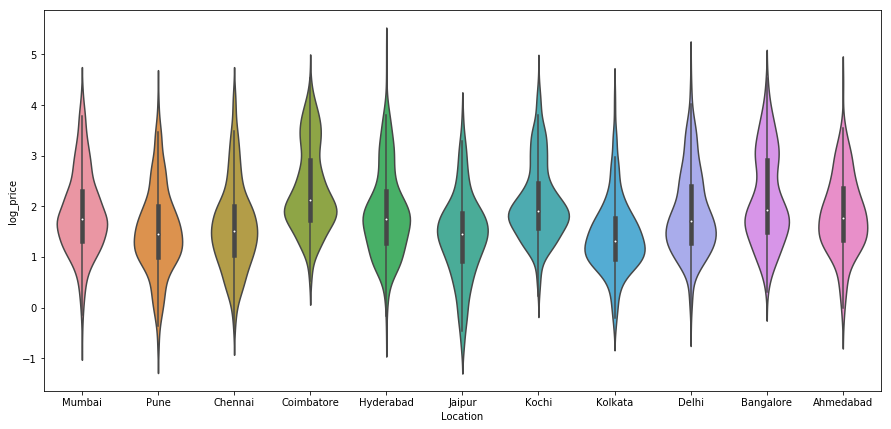

In [13]:
print("Check Missing Values in Location Column ",df['Location'].isnull().sum())

# Plot violin plots of prices across Cities

plt.figure(figsize = (15,7))
sns.violinplot(x = 'Location', y = 'log_price', data = df) 

##### Plot summary - (The differences in prices across cities looks significant - atleast in the log scale. We shall keep this feature)

### Check Predictive power of Location using the method of (Mean Value Replacement) - Computes mean across locations on training data and uses that to predict on test dataset

In [14]:
df_train, df_test = train_test_split(df[['Location','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_loc_mvr = pd.DataFrame(df_train.groupby('Location')['Price'].mean().reset_index())
df_loc_mvr.columns = ['Location','location_mean_Price']

df_train  = pd.merge(df_train,df_loc_mvr, on = 'Location',how = 'left')
df_test  = pd.merge(df_test,df_loc_mvr, on = 'Location',how = 'left')

print('RMSE for MVR(Location) is', rmse_score(df_test.Price.values,df_test.location_mean_Price.values))
print('RMSLE for MVR(Location) is', rmsle_score(df_test.Price.values,df_test.location_mean_Price.values))

(4514, 2)
(1505, 2)
RMSE for MVR(Location) is 10.695666896071439
RMSLE for MVR(Location) is 0.7637835583940563


## 3.3 EDA for 'Year' - (Relation with Price) - Creating 'Age' Feature

Check Missing Values in Year Column  0


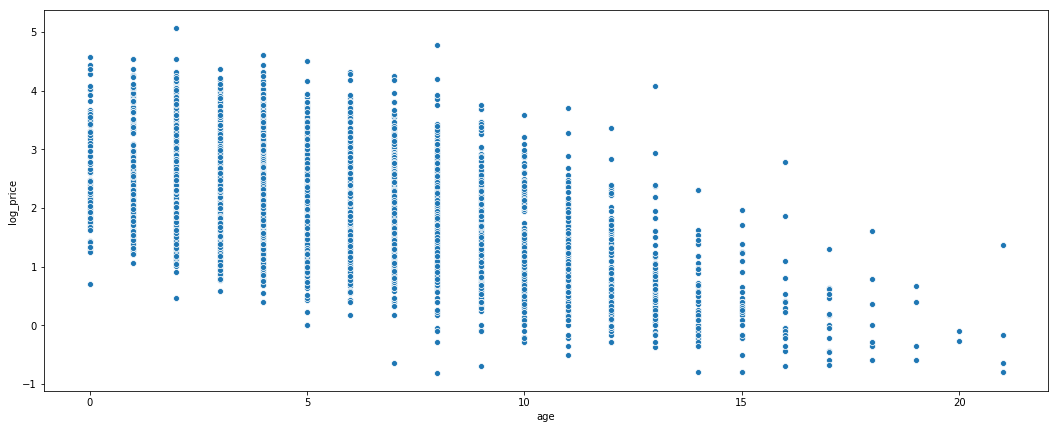

In [15]:
print("Check Missing Values in Year Column ",df['Year'].isnull().sum())
df['age'] = 2019 - df['Year']
df.head(5)

plt.figure(figsize = (18,7))
#sns.violinplot(x = 'age', y = 'log_price', data = df) 
sns.scatterplot(x = 'age', y = 'log_price', data = df) 

##### Plot summary - (Interesting, We see a downward trend although the variance in every age is quite high)

#### check predictive power of 'age' (Mean value replacement)

In [16]:
df_train, df_test = train_test_split(df[['age','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train.groupby('age')['Price'].mean().reset_index())
df_age_mvr.columns = ['age','age_mean_Price']

df_train  = pd.merge(df_train,df_age_mvr, on = 'age',how = 'left')
df_test  = pd.merge(df_test,df_age_mvr, on = 'age',how = 'left')

print('RMSE for MVR(age) is', rmse_score(df_test.Price.values,df_test.age_mean_Price.values))
print('RMSLE for MVR(age) is', rmsle_score(df_test.Price.values,df_test.age_mean_Price.values))

(4514, 2)
(1505, 2)
RMSE for MVR(age) is 10.210938318986136
RMSLE for MVR(age) is 0.6994932869235612


## 3.4 EDA - (Kilometers Driven) - Relation with Price

Check Missing Values in kms driven Column  0


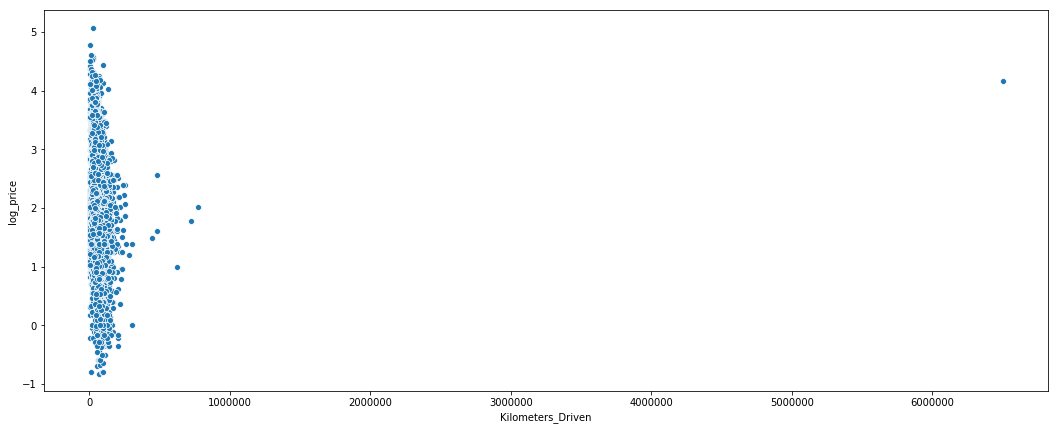

In [17]:
print("Check Missing Values in kms driven Column ",df['Kilometers_Driven'].isnull().sum())


plt.figure(figsize = (18,7))
sns.scatterplot(x = 'Kilometers_Driven', y = 'log_price', data = df) 
#plt.xlim(0,250000)
plt.show()

##### Plot summary - From the graph, we have detected couple of  outlier points here   - let's remove these outlier points

#### <a id = 'section100'>Outlier Handling</a>

#### Plot 0-100 percentile values of 'kms_driven'

+------------+------------+
| Percentile | kms_driven |
+------------+------------+
|     0      |   171.0    |
|     5      |  13007.4   |
|     10     |  20000.0   |
|     15     |  25000.0   |
|     20     |  29960.4   |
|     25     |  34000.0   |
|     30     |  38000.0   |
|     35     |  42000.0   |
|     40     |  45350.8   |
|     45     |  50000.0   |
|     50     |  53000.0   |
|     55     |  57000.0   |
|     60     |  60006.8   |
|     65     |  64752.4   |
|     70     |  68390.0   |
|     75     |  73000.0   |
|     80     |  79000.0   |
|     85     |  85429.6   |
|     90     |  97000.0   |
|     95     |  120000.0  |
|    100     | 6500000.0  |
+------------+------------+


Text(0.5, 1.0, '0-100 percentiles')

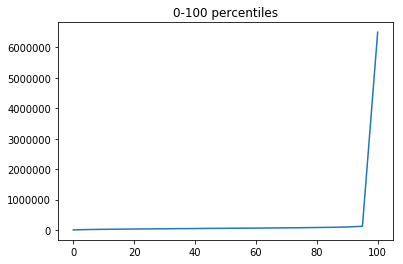

In [18]:
x = PrettyTable()
x.field_names = ["Percentile", "kms_driven"]

'''This code snippet below calculates percentiles for the 'kilometers' feature '''
percentiles = []
kms = []

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(df['Kilometers_Driven'].values,i), 3)])
    percentiles.append(i)
    kms.append(np.round(np.percentile(df['Kilometers_Driven'].values,i), 3))
print(x)
plt.plot(percentiles,kms)
plt.title('0-100 percentiles')

#### Plot 95-100 percentile values of 'kms_driven'

+------------+------------+
| Percentile | kms_driven |
+------------+------------+
|     95     |  120000.0  |
|     96     | 127022.84  |
|     97     | 136559.92  |
|     98     |  150000.0  |
|     99     |  172829.0  |
|    100     | 6500000.0  |
+------------+------------+


Text(0.5, 1.0, '95-100 percentiles')

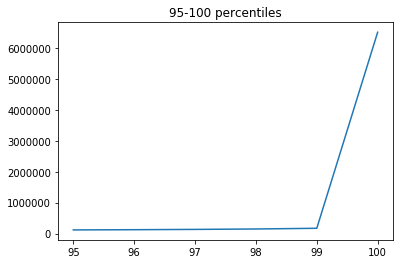

In [19]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "kms_driven"]

percentiles = []
kms_driven = []

for i in range(95,101,1):
    x.add_row([i,np.round(np.percentile(df['Kilometers_Driven'].values,i), 3)])
    percentiles.append(i)
    kms_driven.append(np.round(np.percentile(df['Kilometers_Driven'].values,i), 3))
print(x)
plt.plot(percentiles,kms_driven)
plt.title('95-100 percentiles')

#### Plot 99-100 percentile values of 'kms_driven'

In [20]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "kms_driven"]

percentiles = []
kms_driven = []

for i in np.linspace(99,100,100):
    x.add_row([round(i,2),np.round(np.percentile(df['Kilometers_Driven'].values,i), 3)])
    percentiles.append(i)
    kms_driven.append(np.round(np.percentile(df['Kilometers_Driven'].values,i), 3))
print(x)

+------------+-------------+
| Percentile |  kms_driven |
+------------+-------------+
|    99.0    |   172829.0  |
|   99.01    |   173000.0  |
|   99.02    |  173107.273 |
|   99.03    |  174930.909 |
|   99.04    |  176251.515 |
|   99.05    |  176859.394 |
|   99.06    |  177467.273 |
|   99.07    |  178021.042 |
|   99.08    |  178191.248 |
|   99.09    |  178489.455 |
|    99.1    |  178927.127 |
|   99.11    |   179000.0  |
|   99.12    |  179003.665 |
|   99.13    |  179023.118 |
|   99.14    |  179351.733 |
|   99.15    |  179940.16  |
|   99.16    |   180000.0  |
|   99.17    |   180000.0  |
|   99.18    |   180000.0  |
|   99.19    |  181922.424 |
|    99.2    |  185083.394 |
|   99.21    |  186065.887 |
|   99.22    |  187321.06  |
|   99.23    |  189339.825 |
|   99.24    |   190000.0  |
|   99.25    |  190033.939 |
|   99.26    |  191249.697 |
|   99.27    |  192232.727 |
|   99.28    |  192840.606 |
|   99.29    |  193113.915 |
|    99.3    |  193296.047 |
|   99.31    |

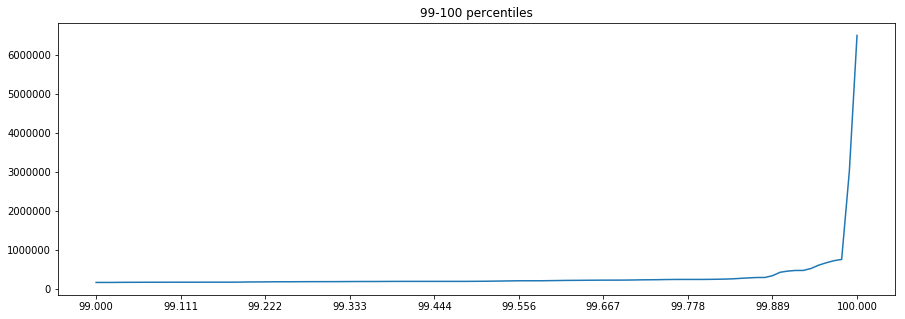

In [21]:
plt.figure(figsize=(15,5))
plt.plot(percentiles,kms_driven)
'''
# zip joins x and y coordinates in pairs
for x,y in zip(percentiles,prices):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
'''

plt.xticks(np.linspace(99,100,10))
plt.title('99-100 percentiles')
plt.show()

In [22]:
print("Mean + 3*SD is ",np.mean(df['Kilometers_Driven']) + 3*(df['Kilometers_Driven'].std()))
print("Q3 + 1.5*(IQR) is ",np.percentile(df['Kilometers_Driven'].values,75) + 1.5*(np.percentile(df['Kilometers_Driven'].values,75) - np.percentile(df['Kilometers_Driven'].values,25)))
print("Median Abs Deviation is ",abs(df['Kilometers_Driven'] - df['Kilometers_Driven'].median()).median())

Mean + 3*SD is  332544.90991447563
Q3 + 1.5*(IQR) is  131500.0
Median Abs Deviation is  19483.0


In [23]:
kms_list = list(df.Kilometers_Driven.values)
kms_list.sort(reverse = True)

In [24]:
print('Highest 10 values in kms_driven are ',kms_list[:10])

Highest 10 values in kms_driven are  [6500000, 775000, 720000, 620000, 480000, 480000, 445000, 300000, 299322, 282000]


##### Outlier removal technique - We can take 300,000 kms as bechmark and remove the rest as outliers..

##### reference - https://www.quora.com/Does-an-Indian-car-or-engine-last-upto-5-or-6-lakh-kilometers

In [25]:
df = df[df.Kilometers_Driven < 300000]

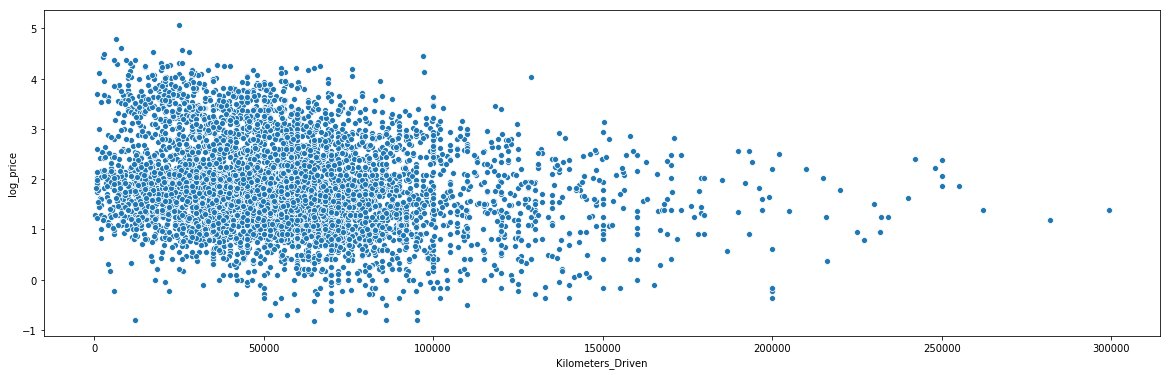

In [26]:
plt.figure(figsize = (20,6))
sns.scatterplot(x = 'Kilometers_Driven', y = 'log_price', data = df) 
#plt.xlim(0,250000)
plt.show()

##### Plot summary  - The outliers are now removed

#### check predictive power of 'kms_driven' (Build linear model of Price ~ kms)

In [28]:
df_train, df_test = train_test_split(df[['Kilometers_Driven','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train.Kilometers_Driven.values.reshape(-1,1), df_train.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.Kilometers_Driven.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

(4508, 2)
(1503, 2)
Best score  10.854168698149602
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  11.32364535202864
Test RMSLE is  0.8139308721904331


## 3.5 EDA -  'Fuel Type' - Relation with Price

Check Missing Values in Fuel_Type Column  0


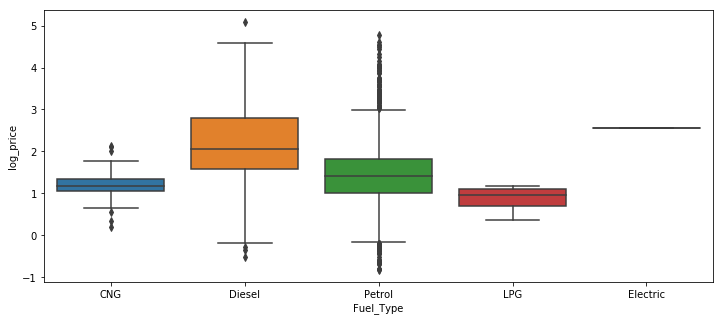

In [29]:
print("Check Missing Values in Fuel_Type Column ",df['Fuel_Type'].isnull().sum())

plt.figure(figsize = (12,5))
sns.boxplot(x = 'Fuel_Type', y = 'log_price', data = df) 

#### check predictive power of 'fuel_type' (Mean value replacement)

In [30]:
df_train, df_test = train_test_split(df[['Fuel_Type','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train.groupby('Fuel_Type')['Price'].mean().reset_index())
df_age_mvr.columns = ['Fuel_Type','Fuel_Type_mean_Price']

df_train  = pd.merge(df_train,df_age_mvr, on = 'Fuel_Type',how = 'left')
df_test  = pd.merge(df_test,df_age_mvr, on = 'Fuel_Type',how = 'left')

print('RMSE for MVR(Fuel_Type) is', rmse_score(df_test.Price.values,df_test.Fuel_Type_mean_Price.values))
print('RMSLE for MVR(Fuel_Type) is', rmsle_score(df_test.Price.values,df_test.Fuel_Type_mean_Price.values))

(4508, 2)
(1503, 2)
RMSE for MVR(Fuel_Type) is 11.90692743704189
RMSLE for MVR(Fuel_Type) is 0.7326015551682359


## 3.6 EDA -  'Transmission' - Relation with Price

Check Missing Values in Transmission Column  0


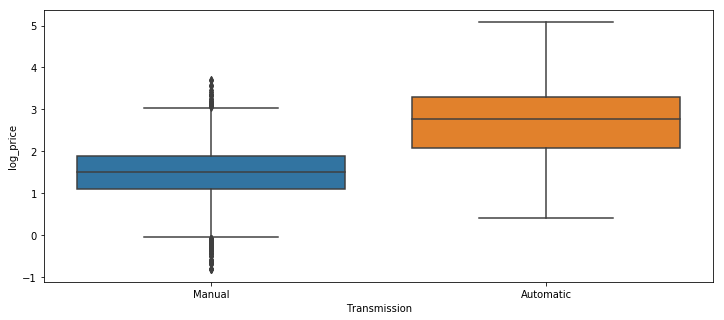

In [31]:
print("Check Missing Values in Transmission Column ",df['Transmission'].isnull().sum())

plt.figure(figsize = (12,5))
sns.boxplot(x = 'Transmission', y = 'log_price', data = df) 

In [32]:
df_train, df_test = train_test_split(df[['Transmission','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train.groupby('Transmission')['Price'].mean().reset_index())
df_age_mvr.columns = ['Transmission','Transmission_mean_Price']

df_train  = pd.merge(df_train,df_age_mvr, on = 'Transmission',how = 'left')
df_test  = pd.merge(df_test,df_age_mvr, on = 'Transmission',how = 'left')

print('RMSE for MVR(Transmission) is', rmse_score(df_test.Price.values,df_test.Transmission_mean_Price.values))
print('RMSLE for MVR(Transmission) is', rmsle_score(df_test.Price.values,df_test.Transmission_mean_Price.values))

(4508, 2)
(1503, 2)
RMSE for MVR(Transmission) is 9.55297798044842
RMSLE for MVR(Transmission) is 0.5971735124735518


## 3.7 EDA -  'Owner Type' - Relation with Price

Check Missing Values in Owner_Type Column  0


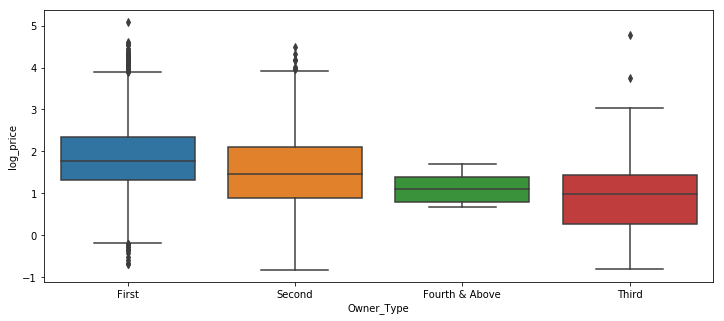

In [33]:
print("Check Missing Values in Owner_Type Column ",df['Owner_Type'].isnull().sum())

plt.figure(figsize = (12,5))
sns.boxplot(x = 'Owner_Type', y = 'log_price', data = df) 

In [34]:
df_train, df_test = train_test_split(df[['Owner_Type','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train.groupby('Owner_Type')['Price'].mean().reset_index())
df_age_mvr.columns = ['Owner_Type','Owner_Type_mean_Price']

df_train  = pd.merge(df_train,df_age_mvr, on = 'Owner_Type',how = 'left')
df_test  = pd.merge(df_test,df_age_mvr, on = 'Owner_Type',how = 'left')

print('RMSE for MVR(Owner_Type) is', rmse_score(df_test.Price.values,df_test.Owner_Type_mean_Price.values))
print('RMSLE for MVR(Owner_Type) is', rmsle_score(df_test.Price.values,df_test.Owner_Type_mean_Price.values))

(4508, 2)
(1503, 2)
RMSE for MVR(Owner_Type) is 10.107672737042135
RMSLE for MVR(Owner_Type) is 0.8043724401273192


## 3.8 - EDA -  'Mileage' - Relation with Price

In [35]:
print("Check Missing Values in Mileage Column ",df['Mileage'].isnull().sum())
print("Check zero Values in Mileage Column ",len(df[df.Mileage == '0.0 kmpl']))

Check Missing Values in Mileage Column  2
Check zero Values in Mileage Column  68


##### Summary  - Let's just replace this NA values with 0 - then we will think of how to handle them...(0 values also need to be handled - because mileage cant be 0)

Check Missing Values in Mileage Column  2
Check Now -  Missing Values in Mileage Column  0


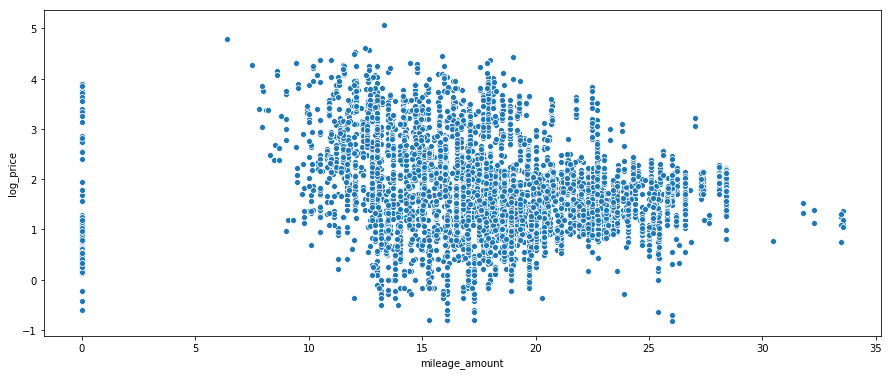

In [36]:
print("Check Missing Values in Mileage Column ",df['Mileage'].isnull().sum())
df['Mileage'] = df['Mileage'].fillna('0.0 kmpl')
print("Check Now -  Missing Values in Mileage Column ",df['Mileage'].isnull().sum())

new = df["Mileage"].str.split(" ", n = 1, expand = True)
df["mileage_amount"]= new[0] 
# making separate last name column from new data frame 
df["mileage_unit"]= new[1] 
df['mileage_amount'] = pd.to_numeric(df['mileage_amount']) 

df = df.drop(['mileage_unit'],axis = 1)

plt.figure(figsize = (15,6))
sns.scatterplot(x = 'mileage_amount', y = 'log_price', data = df)

##### Plot summary - Clearly , the '0' values that we see above are not acceptable - because mileage can't be zero. So, We shall treat these as missing values and use some form of 'imputation' to handle these.

##### For now, let's check the predictive power of (price ~ mileage) for non zero mileage values..

In [37]:
df_cons = df[df.mileage_amount != 0]
df_train, df_test = train_test_split(df_cons[['mileage_amount','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train.mileage_amount.values.reshape(-1,1), df_train.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.mileage_amount.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

(4455, 2)
(1486, 2)
Best score  10.413245356839004
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  10.681574417189623
Test RMSLE is  0.7946085066310891


## 3.9 - EDA -  'Engine CC' - Relation with Price

In [38]:
print("Check Missing Values in Engine Column ",df['Engine'].isnull().sum())

Check Missing Values in Engine Column  36


##### Conclusion - for now, lets replace 'NA' values with 0 - we shall use imputation later to handle them

Check Missing Values in Engine Column  36
Check Now -  Missing Values in Engine Column  0


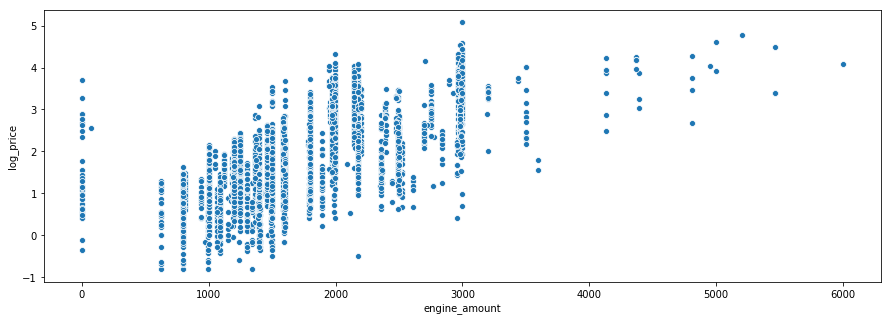

In [39]:
print("Check Missing Values in Engine Column ",df['Engine'].isnull().sum())
df['Engine'] = df['Engine'].fillna('0 CC')
print("Check Now -  Missing Values in Engine Column ",df['Engine'].isnull().sum())

new = df["Engine"].str.split(" ", n = 1, expand = True)
df["engine_amount"]= new[0] 
# making separate last name column from new data frame 
df["engine_unit"]= new[1] 
df['engine_amount'] = pd.to_numeric(df['engine_amount']) 

df = df.drop(['engine_unit'],axis = 1)

plt.figure(figsize = (15,5))
sns.scatterplot(x = 'engine_amount', y = 'log_price', data = df)

#### predictive power of engine (Linear model with Price ~ Engine cc)

In [40]:
df_cons = df[df.engine_amount != '0 CC']
df_train, df_test = train_test_split(df_cons[['engine_amount','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train.engine_amount.values.reshape(-1,1), df_train.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.engine_amount.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

(4508, 2)
(1503, 2)
Best score  8.526566356161753
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  8.48115034496501
Test RMSLE is  0.5714562850263358


## 3.10 - EDA -  'Power bhp' - Relation with Price

In [41]:
print("Check Missing Values in Power Column ",df['Power'].isnull().sum())

Check Missing Values in Power Column  36


Check Missing Values in Power Column  36
Check Now --- Missing Values in Power Column  0


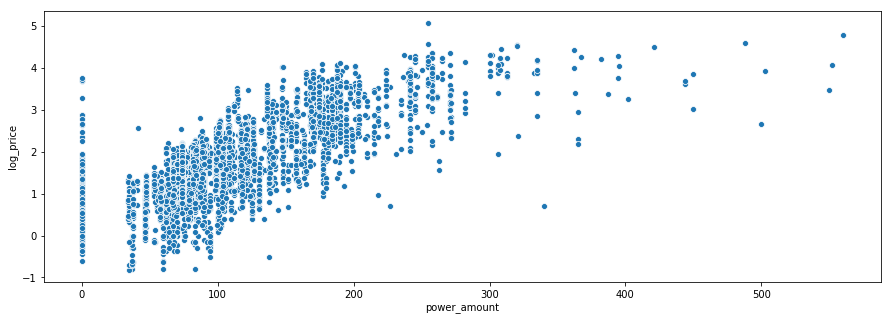

In [42]:
print("Check Missing Values in Power Column ",df['Power'].isnull().sum())
df['Power'] = df['Power'].fillna('0 bhp')
print("Check Now --- Missing Values in Power Column ",df['Power'].isnull().sum())

# remove the 'bhp' from the column and keep only the numeric values of the Power
new = df["Power"].str.split(" ", n = 1, expand = True)
df["power_amount"]= new[0] 
df["power_amount"] = df["power_amount"].replace(['null'],0)

# making separate last name column from new data frame 
df["power_unit"]= new[1] 
df['power_amount'] = pd.to_numeric(df['power_amount']) 

df = df.drop(['power_unit'],axis = 1)

plt.figure(figsize = (15,5))
sns.scatterplot(x = 'power_amount', y = 'log_price', data = df)

##### Plot summary  - There appears to be an increasing trend of power with log(price) - although variability is quite high

#### Predictive power of 'power'

In [43]:
df_cons = df[df.power_amount != '0 bhp']
df_train, df_test = train_test_split(df_cons[['power_amount','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train.power_amount.values.reshape(-1,1), df_train.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.power_amount.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

(4508, 2)
(1503, 2)
Best score  7.453969445003855
Best params  {'fit_intercept': True, 'normalize': False}
Test RMSE is  7.22296707426387
Test RMSLE is  0.4722370973303623


## 3.11 - EDA for 'Num(Seats)' - Relation with Price

Check Missing Values in Seats Column  42
Check Now -  Missing Values in Seats Column  0


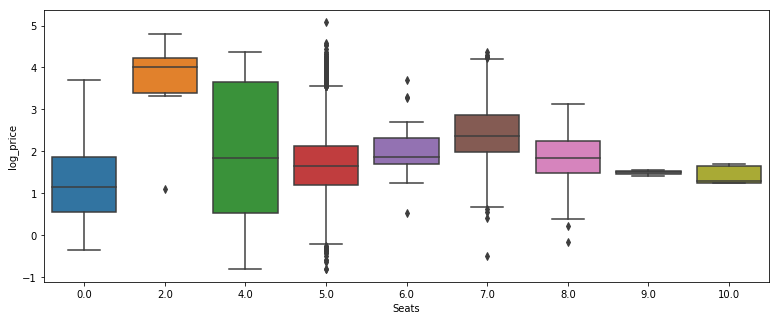

In [44]:
print("Check Missing Values in Seats Column ",df['Seats'].isnull().sum())
df['Seats'] = df['Seats'].fillna(0)
print("Check Now -  Missing Values in Seats Column ",df['Seats'].isnull().sum())

plt.figure(figsize = (13,5))
sns.boxplot(x = 'Seats', y = 'log_price', data = df) 

#### Predictive power of 'seats'

In [45]:
df_cons = df[df.Seats != 0]
df_train, df_test = train_test_split(df_cons[['Seats','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train.groupby('Seats')['Price'].mean().reset_index())
df_age_mvr.columns = ['Seats','Seats_mean_Price']

df_train  = pd.merge(df_train,df_age_mvr, on = 'Seats',how = 'left')
df_test  = pd.merge(df_test,df_age_mvr, on = 'Seats',how = 'left')

print('RMSE for MVR(Seats) is', rmse_score(df_test.Price.values,df_test.Seats_mean_Price.values))
print('RMSLE for MVR(Seats) is', rmsle_score(df_test.Price.values,df_test.Seats_mean_Price.values))

(4476, 2)
(1492, 2)
RMSE for MVR(Seats) is 10.507591881269965
RMSLE for MVR(Seats) is 0.789384837480173


## 3.12 - EDA for 'Car Name' - Relation with Price

In [46]:
print('Missing values if any - ',df.Name.isnull().sum())
print('Unique number of Car Name is',df.Name.nunique())

Missing values if any -  0
Unique number of Car Name is 1875


### Text Pre-processing of 'Car Name'

In [ ]:
'''
The code snippet below performs text preprocessing - it performs decontraction,stop words removal, regexp special
characters removal, lower case conversion
'''

In [47]:
df.Name = df.Name.str.lower()
#reference - www.appliedaicourse.com
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords_eng = set(stopwords.words('english'))

preprocessed_names = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Name'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords_eng)
    preprocessed_names.append(sent.lower().strip())
    
df['preprocessed_names'] = preprocessed_names

100%|██████████| 6011/6011 [00:00<00:00, 71971.25it/s]


In [48]:
print('Missing values if any - ',df.preprocessed_names.isnull().sum())
print('Unique number of Car Name is',df.preprocessed_names.nunique())

Missing values if any -  0
Unique number of Car Name is 1763


In [49]:
df_name_eda = pd.DataFrame(df.groupby('preprocessed_names').size().reset_index())
df_name_eda.columns = ['car_name','count']
df_name_eda = df_name_eda.sort_values(by = 'count',ascending = False).reset_index()
df_name_eda = df_name_eda.drop(columns = 'index')
df_name_eda.head(15)

,car_name,count
0,maruti swift dzire vdi,50
1,mahindra xuv500 w8 2wd,49
2,maruti swift vdi,45
3,hyundai i10 sportz,39
4,honda city 1 5 mt,34
5,hyundai verna 1 6 sx vtvt,33
6,maruti swift vdi bsiv,31
7,maruti swift dzire vxi,31
8,maruti ritz vdi,30
9,toyota fortuner 3 0 diesel,29


Text(0.5, 1.0, 'Car Names by Frequency')

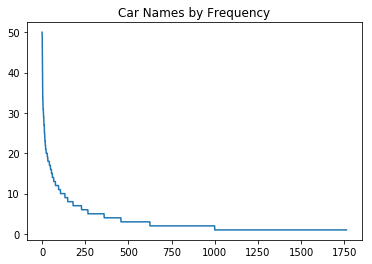

In [50]:
plt.plot(df_name_eda.index.values,df_name_eda['count'])
plt.title('Car Names by Frequency')

##### Plot summary  - Very few cars have many appereances in the car title

In [51]:
list(df_name_eda.car_name.values)[0:10]

['maruti swift dzire vdi',
 'mahindra xuv500 w8 2wd',
 'maruti swift vdi',
 'hyundai i10 sportz',
 'honda city 1 5 mt',
 'hyundai verna 1 6 sx vtvt',
 'maruti swift vdi bsiv',
 'maruti swift dzire vxi',
 'maruti ritz vdi',
 'toyota fortuner 3 0 diesel']

### Feature Extraction & EDA ----- Extracting the 'car_brand' as a feature from 'Name' (As seen from the car titles, The first word represents the car brand)

In [53]:
df['car_brand'] = ''
i = 0
for x in tqdm_notebook(df.preprocessed_names.values):
    df['car_brand'][i] =   x.split()[0]
    i = i + 1

### Feature Extraction & EDA ----- 'car_name' -  Extracting the first 2 words as a feature from 'Name' (First 2 words most likely represent the car name - which is a combination of the car (brand and model))

In [54]:
df['car_name2'] = ''
i = 0
for x in tqdm_notebook(df.preprocessed_names.values):
    df['car_name2'][i] =   x.split()[0] + ' ' + x.split()[1]
    i = i + 1
    
################################################################################

df['car_name3'] = ''
i = 0
for x in tqdm_notebook(df.preprocessed_names.values):
    if(len(x.split()) > 2):
        df['car_name3'][i] =   x.split()[0] + ' ' + x.split()[1] + ' ' + x.split()[2]
        i = i + 1
    else:
        df['car_name3'][i] =   x.split()[0] + ' ' + x.split()[1] 
        i = i+1

### Feature Extraction & EDA ----- 'car_name' -  Removing numbers 

In [55]:
df['preprocessed_names_num_removed'] = ''
i = 0
for x in tqdm_notebook(df.preprocessed_names.values):
    df['preprocessed_names_num_removed'][i] =   re.sub(r'\d+', '', str(x))
    i = i + 1

### check predictive power of 'Name'

#### 1. feature - 'preprocessed_names' (BOW, TF-IDF)

In [56]:
df_train, df_test = train_test_split(df[['preprocessed_names','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.preprocessed_names.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params BOW ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.preprocessed_names.values)
print("BOW Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("BOW Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

##############################################################################################################################


df_train, df_test = train_test_split(df[['preprocessed_names','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None],
             'vect__sublinear_tf' : [True,False],
             'vect__smooth_idf' : [True,False],
             'vect__use_idf' : [True,False]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.preprocessed_names.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params TFIDF ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.preprocessed_names.values)
print("TFIDF Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("TFIDF Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

Best params BOW  {'vect__max_features': None, 'vect__ngram_range': (1, 3)}
BOW Test RMSE is  4.721551469965436
BOW Test RMSLE is  0.2931520729618471
Best params TFIDF  {'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__smooth_idf': True, 'vect__sublinear_tf': True, 'vect__use_idf': False}
TFIDF Test RMSE is  4.799789739350892
TFIDF Test RMSLE is  0.31410968800901223


#### 2. feature - 'car_brand' (BOW, TF-IDF)

In [57]:
df_train, df_test = train_test_split(df[['car_brand','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.car_brand.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params BOW ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.car_brand.values)
print("BOW Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("BOW Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

##############################################################################################################################


df_train, df_test = train_test_split(df[['car_brand','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None],
             'vect__sublinear_tf' : [True,False],
             'vect__smooth_idf' : [True,False],
             'vect__use_idf' : [True,False]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.car_brand.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params TFIDF ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.car_brand.values)
print("TFIDF Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("TFIDF Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

Best params BOW  {'vect__max_features': 50, 'vect__ngram_range': (1, 1)}
BOW Test RMSE is  12.036886510804887
BOW Test RMSLE is  0.8059190125503127
Best params TFIDF  {'vect__max_features': 50, 'vect__ngram_range': (1, 1), 'vect__smooth_idf': True, 'vect__sublinear_tf': True, 'vect__use_idf': True}
TFIDF Test RMSE is  11.119211091099134
TFIDF Test RMSLE is  0.7919018259859902


#### 3. feature - 'car_name2' (BOW, TF-IDF)

In [58]:
df_train, df_test = train_test_split(df[['car_name2','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.car_name2.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params BOW ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.car_name2.values)
print("BOW Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("BOW Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

##############################################################################################################################


df_train, df_test = train_test_split(df[['car_name2','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None],
             'vect__sublinear_tf' : [True,False],
             'vect__smooth_idf' : [True,False],
             'vect__use_idf' : [True,False]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.car_name2.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params TFIDF ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.car_name2.values)
print("TFIDF Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("TFIDF Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

Best params BOW  {'vect__max_features': 200, 'vect__ngram_range': (1, 2)}
BOW Test RMSE is  11.078685497166795
BOW Test RMSLE is  0.8042894044810565
Best params TFIDF  {'vect__max_features': 100, 'vect__ngram_range': (1, 2), 'vect__smooth_idf': False, 'vect__sublinear_tf': True, 'vect__use_idf': True}
TFIDF Test RMSE is  10.535656706349693
TFIDF Test RMSLE is  0.7902475139367278


#### 4. feature - 'car_name3' (BOW, TF-IDF)

In [59]:
df_train, df_test = train_test_split(df[['car_name3','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.car_name3.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params BOW ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.car_name3.values)
print("BOW Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("BOW Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

##############################################################################################################################


df_train, df_test = train_test_split(df[['car_name3','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None],
             'vect__sublinear_tf' : [True,False],
             'vect__smooth_idf' : [True,False],
             'vect__use_idf' : [True,False]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.car_name3.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params TFIDF ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.car_name3.values)
print("TFIDF Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("TFIDF Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

Best params BOW  {'vect__max_features': 200, 'vect__ngram_range': (1, 1)}
BOW Test RMSE is  11.006982010060124
BOW Test RMSLE is  0.8039054959721563
Best params TFIDF  {'vect__max_features': 500, 'vect__ngram_range': (1, 3), 'vect__smooth_idf': True, 'vect__sublinear_tf': True, 'vect__use_idf': False}
TFIDF Test RMSE is  11.95704385885252
TFIDF Test RMSLE is  0.8046196595133237


#### 5. feature - 'preprocessed_names_num_removed' (BOW, TF-IDF)

In [60]:
df_train, df_test = train_test_split(df[['preprocessed_names_num_removed','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.preprocessed_names_num_removed.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params BOW ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.preprocessed_names_num_removed.values)
print("BOW Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("BOW Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

##############################################################################################################################


df_train, df_test = train_test_split(df[['preprocessed_names_num_removed','Price']], test_size=0.25)
#print(df_train.shape)
#print(df_test.shape)


###############################################################

text_reg = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', LinearRegression())])

####################################################################

parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
             'vect__max_features' : [50,100,200,500,None],
             'vect__sublinear_tf' : [True,False],
             'vect__smooth_idf' : [True,False],
             'vect__use_idf' : [True,False]}

gs_reg = GridSearchCV(text_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(df_train.preprocessed_names_num_removed.values, df_train.Price.values)


#######################################################################
#print("Best score ",-gs_reg.best_score_)
print("Best params TFIDF ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test.preprocessed_names_num_removed.values)
print("TFIDF Test RMSE is ",rmse_score(df_test.Price.values, y_predicted))
print("TFIDF Test RMSLE is ",rmsle_score(df_test.Price.values, y_predicted))

Best params BOW  {'vect__max_features': None, 'vect__ngram_range': (1, 4)}
BOW Test RMSE is  10.87369913246544
BOW Test RMSLE is  0.7996526312553905
Best params TFIDF  {'vect__max_features': None, 'vect__ngram_range': (1, 4), 'vect__smooth_idf': False, 'vect__sublinear_tf': True, 'vect__use_idf': True}
TFIDF Test RMSE is  11.926223654302904
TFIDF Test RMSLE is  0.7999990792079351


#### 6. feature - 'preprocessed_names' - (Mean Val Repl.)

In [61]:
df_train, df_test = train_test_split(df[['preprocessed_names','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train.groupby('preprocessed_names')['Price'].mean().reset_index())
df_age_mvr.columns = ['preprocessed_names','preprocessed_names_mean_Price']

df_train  = pd.merge(df_train,df_age_mvr, on = 'preprocessed_names',how = 'left')
df_test  = pd.merge(df_test,df_age_mvr, on = 'preprocessed_names',how = 'left')
df_test['preprocessed_names_mean_Price'].fillna(np.mean(df_train.Price),inplace = True)

print('RMSE for MVR(preprocessed_names) is', rmse_score(df_test.Price.values,df_test.preprocessed_names_mean_Price.values))
print('RMSLE for MVR(preprocessed_names) is', rmsle_score(df_test.Price.values,df_test.preprocessed_names_mean_Price.values))

(4508, 2)
(1503, 2)
RMSE for MVR(preprocessed_names) is 8.645202332748257
RMSLE for MVR(preprocessed_names) is 0.4579303848335045


## 3.13 - EDA Summary Table

In [62]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S:No.","Feature", "Model Used", "Best Hyperparams","Test RMSE","Test RMSLE"]

x.add_row([1,"---", "Mean Model", "",11.57,0.80])
x.add_row([2,"---", "Median Model", "",12.40,0.78])
x.add_row([3,"Location", "Mean Val Repl", "",10.19,0.79])
x.add_row([4,"Age", "Mean Val Repl", "",10.06,0.70])
x.add_row([5,"kms_driven (outliers removed)", "LinearRegression", "int=T,norm=F",10.53,0.79])
x.add_row([6,"Fuel Type", "Mean Val Repl", "",9.84,0.72])
x.add_row([7,"Transmission Type", "Mean Val Repl", "",8.44,0.60])
x.add_row([8,"Owner Type", "Mean Val Repl", "",11.76,0.81])
x.add_row([9,"Mileage (non missing values only)", "LinearRegression", "int=T,norm=T",10.06,0.78])
x.add_row([10,"Engine (non missing values only)", "LinearRegression", "int=T,norm=T",8.92,0.56])
x.add_row([11,"Power (non missing values only)", "LinearRegression", "int=T,norm=T",7,0.46])
x.add_row([12,"Seats (non missing values only)", "Mean Val Repl", "",10.74,0.79])

x.add_row([13,"Preprocessed Names", "BOW (Lr.Reg)", "ngram(1,4) ",4.85,0.29])
x.add_row([14,"Preprocessed Names", "TF-IDF(Lr.Reg)", "ngram(1,2) last3params =all T",5.64,0.294])

x.add_row([15,"Car brand", "BOW (Lr.Reg)", "ngram(1,1) ",11.39,0.80])
x.add_row([16,"Car brand", "TF-IDF(Lr.Reg)", "ngram(1,1)",9.9,0.79])

x.add_row([17,"Car Name2", "BOW (Lr.Reg)", "ngram(1,1) ",11.28,0.80])
x.add_row([18,"Car Name2", "TF-IDF(Lr.Reg)", "ngram(1,1)",10.03,0.77])

x.add_row([19,"Car name3", "BOW (Lr.Reg)", "ngram(1,2) ",10.54,0.77])
x.add_row([20,"Car name3", "TF-IDF(Lr.Reg)", "ngram(1,1)",12.43,0.79])

x.add_row([21,"Preprocessed Names(Nums remov)", "BOW (Lr.Reg)", "ngram(1,3) ",10.60,0.79])
x.add_row([22,"Preprocessed Names(Nums remov)", "TF-IDF(Lr.Reg)", "ngram(1,2)",11.07,0.79])

x.add_row([23,"Preprocessed Names", "Mean Val Repl", "",6.88,0.45])

print(x)

+-------+-----------------------------------+------------------+-------------------------------+-----------+------------+
| S:No. |              Feature              |    Model Used    |        Best Hyperparams       | Test RMSE | Test RMSLE |
+-------+-----------------------------------+------------------+-------------------------------+-----------+------------+
|   1   |                ---                |    Mean Model    |                               |   11.57   |    0.8     |
|   2   |                ---                |   Median Model   |                               |    12.4   |    0.78    |
|   3   |              Location             |  Mean Val Repl   |                               |   10.19   |    0.79    |
|   4   |                Age                |  Mean Val Repl   |                               |   10.06   |    0.7     |
|   5   |   kms_driven (outliers removed)   | LinearRegression |          int=T,norm=F         |   10.53   |    0.79    |
|   6   |             Fu

# <a id = 'section4'>4. Missing Values Imputation</a>

#### Methods Used ------- Predictive Imputation (Cross Validation based) , Simple Imputation Techniques

##### 4 columns have missing values - (Mileage, Engine, Power, Seats) - We shall try Mean/Median/Mode/RF, XGB based Imputations and cross validate the above results to select the right imputation technique for each of the 4 feature....

## 4.1 - Mileage,Engine,Power,Seats imputation

In [168]:
df_cons = df[['preprocessed_names', #Text based features...
              'Location','age','Kilometers_Driven','Fuel_Type','Transmission','Owner_Type','Seats', # OHE based features..
             'mileage_imputation','engine_imputation','power_imputation','Price' # numeric features...
             ]]

df_train = df_cons[df.Seats != '0']
df_test = df_cons[df.Seats == '0']

print(df_train.shape)
print(df_test.shape)

(5968, 12)
(43, 12)


##### Featurizing 'Seats'

In [169]:
'''This code snippet uses CountVectorizer() to create Numeric encodings, uses fit_transform on train and 
transform on test to avoid any data leakage'''

#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Seats'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Seats'].values)
seats_one_hot_features = vectorizer.get_feature_names()
train_seats_one_hot = vectorizer.transform(df_train['Seats'].values)
print("Shape of Train matrix after one hot encodig ",train_seats_one_hot.shape)


#TEST DATA.....
#vectorizer = CountVectorizer(vocabulary= list(test['teacher_prefix'].unique()), lowercase=False, binary=True)
#vectorizer.fit(test['teacher_prefix'].values)
#print(vectorizer.get_feature_names())
test_seats_one_hot = vectorizer.transform(df_test['Seats'].values)
print("Shape of Test matrix after one hot encodig ",test_seats_one_hot.shape)

Shape of Train matrix after one hot encodig  (5968, 8)
Shape of Test matrix after one hot encodig  (43, 8)


### 1. Mean Imputation

In [204]:
mode_predicted = [stats.mode(df_train.Seats)[0][0]]*len(df_test)

In [205]:
df['Seats_imputation'] = df['Seats']
df['Seats_imputation'][df['Seats_imputation'] == '0'] = mode_predicted

#df_cons = df[df.Seats != 0]
df_train_cv, df_test_cv = train_test_split(df[['Seats_imputation','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train_cv.groupby('Seats_imputation')['Price'].mean().reset_index())
df_age_mvr.columns = ['Seats_imputation','Seats_imputation_mean_Price']

df_train_cv  = pd.merge(df_train_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')
df_test_cv  = pd.merge(df_test_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')

print('RMSE for MVR(Seats) is', rmse_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))
print('RMSLE for MVR(Seats) is', rmsle_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))

(5968, 12)
(43, 12)
RMSE for MVR(Seats) is 10.414274315307624
RMSLE for MVR(Seats) is 0.7699302821215666


In [104]:
#mean_predicted = [np.mean(df_train.Seats)]*len(df_test)

In [171]:

######################################################################################

#df_cons = df[df.mileage_amount != 0]
df_train_cv, df_test_cv = train_test_split(df[['Seats_imputation','Price']], test_size=0.25)


#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train_cv['Seats_imputation'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train_cv['Seats_imputation'].values)
train_seats_one_hot_cv = vectorizer.transform(df_train_cv['Seats_imputation'].values)
print("Shape of Train matrix after one hot encodig ",train_seats_one_hot_cv.shape)


#TEST DATA.....
test_seats_one_hot_cv = vectorizer.transform(df_test_cv['Seats_imputation'].values)
print("Shape of Test matrix after one hot encodig ",test_seats_one_hot_cv.shape)


print(train_seats_one_hot_cv.shape)
print(test_seats_one_hot_cv.shape)

##########################################################################################
lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(train_seats_one_hot_cv, df_train_cv.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(test_seats_one_hot_cv)

print("Test RMSE is ",rmse_score(df_test_cv.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test_cv.Price.values, y_predicted))

Shape of Train matrix after one hot encodig  (4508, 8)
Shape of Test matrix after one hot encodig  (1503, 8)
(4508, 8)
(1503, 8)
Best score  11.205288908532
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  11.057030105196766
Test RMSLE is  0.8083047508444765


### 2. Median Imputation

In [12]:
median_predicted = [np.median(df_train.power_amount)]*len(df_test)
#print('RMSE of Median Mileage is ',rmse_score(df_test.mileage_amount.values,predicted))

In [13]:
df['power_imputation'] = df['power_amount']
df['power_imputation'][df.power_imputation == 0] = median_predicted

######################################################################################

#df_cons = df[df.mileage_amount != 0]
df_train_cv, df_test_cv = train_test_split(df[['power_imputation','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train_cv.power_imputation.values.reshape(-1,1), df_train_cv.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test_cv.power_imputation.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test_cv.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test_cv.Price.values, y_predicted))

(5868, 12)
(143, 12)
Best score  7.195125792363329
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  6.980365571589915
Test RMSLE is  0.5519323889465733


### 3. Linear Regression Imputation

##### Featurizing 'Names' - BOW

In [174]:
vectorizer = CountVectorizer(ngram_range = (1,4)) # Use Ngram range = (1,4)

train_title_bow = vectorizer.fit_transform(df_train.preprocessed_names.values)
test_title_bow = vectorizer.transform(df_test.preprocessed_names.values)

print("Shape of Train matrix after one hot encodig ",train_title_bow.shape)
print("Shape of Test matrix after one hot encodig ",test_title_bow.shape)

Shape of Train matrix after one hot encodig  (5968, 7296)
Shape of Test matrix after one hot encodig  (43, 7296)


##### Featurizing 'Location'

In [175]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Location'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Location'].values)
location_one_hot_features = vectorizer.get_feature_names()
train_loc_one_hot = vectorizer.transform(df_train['Location'].values)
print("Shape of Train matrix after one hot encodig ",train_loc_one_hot.shape)


#TEST DATA.....
#vectorizer = CountVectorizer(vocabulary= list(test['teacher_prefix'].unique()), lowercase=False, binary=True)
#vectorizer.fit(test['teacher_prefix'].values)
#print(vectorizer.get_feature_names())
test_loc_one_hot = vectorizer.transform(df_test['Location'].values)
print("Shape of Test matrix after one hot encodig ",test_loc_one_hot.shape)

Shape of Train matrix after one hot encodig  (5968, 11)
Shape of Test matrix after one hot encodig  (43, 11)


##### Featurizing ''Age"

In [176]:
'''This code snippet performs Feature standardization using mean centering and variance scaling to preprocess numeric data'''

#TRAIN DATA....
train_age_scalar = StandardScaler()
train_age_scalar.fit(df_train['age'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_age_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_age_scalar.var_[0])}")
train_age_standardized = train_age_scalar.transform(df_train['age'].values.reshape(-1, 1))


#TEST DATA....
test_age_scalar = StandardScaler()
test_age_scalar.fit(df_test['age'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_age_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_age_scalar.var_[0])}")
test_age_standardized = test_age_scalar.transform(df_test['age'].values.reshape(-1, 1))

Mean : 5.612265415549598, Standard deviation : 3.2474155059721848
Mean : 9.651162790697674, Standard deviation : 3.8572415793421815


##### Featurizing ''kms_driven"

In [177]:
#TRAIN DATA....

train_kms_scalar = StandardScaler()
train_kms_scalar.fit(df_train['Kilometers_Driven'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_kms_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_kms_scalar.var_[0])}")
train_kms_standardized = train_kms_scalar.transform(df_train['Kilometers_Driven'].values.reshape(-1, 1))


#TEST DATA....
test_kms_scalar = StandardScaler()
test_kms_scalar.fit(df_test['Kilometers_Driven'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_kms_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_kms_scalar.var_[0])}")
test_kms_standardized = test_kms_scalar.transform(df_test['Kilometers_Driven'].values.reshape(-1, 1))

Mean : 57008.71849865952, Standard deviation : 33606.882431030244
Mean : 69727.41860465116, Standard deviation : 33763.205776257186


##### Featurizing ''Fuel Type"

In [178]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Fuel_Type'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Fuel_Type'].values)
fuel_one_hot_features = vectorizer.get_feature_names()
train_fuel_one_hot = vectorizer.transform(df_train['Fuel_Type'].values)
print("Shape of Train matrix after one hot encodig ",train_fuel_one_hot.shape)


#TEST DATA.....
#vectorizer = CountVectorizer(vocabulary= list(test['teacher_prefix'].unique()), lowercase=False, binary=True)
#vectorizer.fit(test['teacher_prefix'].values)
#print(vectorizer.get_feature_names())
test_fuel_one_hot = vectorizer.transform(df_test['Fuel_Type'].values)
print("Shape of Test matrix after one hot encodig ",test_fuel_one_hot.shape)

Shape of Train matrix after one hot encodig  (5968, 5)
Shape of Test matrix after one hot encodig  (43, 5)


##### Featurizing ''Transmission"

In [179]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Transmission'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Transmission'].values)
transmission_one_hot_features = vectorizer.get_feature_names()
train_transmission_one_hot = vectorizer.transform(df_train['Transmission'].values)
print("Shape of Train matrix after one hot encodig ",train_transmission_one_hot.shape)


#TEST DATA.....
#vectorizer = CountVectorizer(vocabulary= list(test['teacher_prefix'].unique()), lowercase=False, binary=True)
#vectorizer.fit(test['teacher_prefix'].values)
#print(vectorizer.get_feature_names())
test_transmission_one_hot = vectorizer.transform(df_test['Transmission'].values)
print("Shape of Test matrix after one hot encodig ",test_transmission_one_hot.shape)

Shape of Train matrix after one hot encodig  (5968, 2)
Shape of Test matrix after one hot encodig  (43, 2)


##### Featurizing ''Owner Type"

In [180]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Owner_Type'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Owner_Type'].values)
owner_one_hot_features = vectorizer.get_feature_names()
train_owner_one_hot = vectorizer.transform(df_train['Owner_Type'].values)
print("Shape of Train matrix after one hot encodig ",train_owner_one_hot.shape)


#TEST DATA.....
#vectorizer = CountVectorizer(vocabulary= list(test['teacher_prefix'].unique()), lowercase=False, binary=True)
#vectorizer.fit(test['teacher_prefix'].values)
#print(vectorizer.get_feature_names())
test_owner_one_hot = vectorizer.transform(df_test['Owner_Type'].values)
print("Shape of Test matrix after one hot encodig ",test_owner_one_hot.shape)

Shape of Train matrix after one hot encodig  (5968, 4)
Shape of Test matrix after one hot encodig  (43, 4)


##### Featurizing ''Seats"

In [21]:
'''
df_train.Seats = df_train.Seats.astype(str)
df_test.Seats = df_test.Seats.astype(str)
'''

In [22]:
'''
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Seats'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Seats'].values)
seats_one_hot_features = vectorizer.get_feature_names()
train_seats_one_hot = vectorizer.transform(df_train['Seats'].values)
print("Shape of Train matrix after one hot encodig ",train_seats_one_hot.shape)


#TEST DATA.....
#vectorizer = CountVectorizer(vocabulary= list(test['teacher_prefix'].unique()), lowercase=False, binary=True)
#vectorizer.fit(test['teacher_prefix'].values)
#print(vectorizer.get_feature_names())
test_seats_one_hot = vectorizer.transform(df_test['Seats'].values)
print("Shape of Test matrix after one hot encodig ",test_seats_one_hot.shape)
'''

Shape of Train matrix after one hot encodig  (5868, 9)
Shape of Test matrix after one hot encodig  (143, 9)


##### Featurizing ''mileage_imputation"

In [181]:
#TRAIN DATA....

train_mileage_scalar = StandardScaler()
train_mileage_scalar.fit(df_train['mileage_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_mileage_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_mileage_scalar.var_[0])}")
train_mileage_standardized = train_mileage_scalar.transform(df_train['mileage_imputation'].values.reshape(-1, 1))


#TEST DATA....
test_mileage_scalar = StandardScaler()
test_mileage_scalar.fit(df_test['mileage_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_mileage_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_mileage_scalar.var_[0])}")
test_mileage_standardized = test_mileage_scalar.transform(df_test['mileage_imputation'].values.reshape(-1, 1))

Mean : 18.34017666518187, Standard deviation : 4.167351917537811
Mean : 16.48584214165699, Standard deviation : 2.5706938048190584


##### Featurizing ''engine_imputation"

In [182]:
#TRAIN DATA....

train_engine_scalar = StandardScaler()
train_engine_scalar.fit(df_train['engine_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_engine_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_engine_scalar.var_[0])}")
train_engine_standardized = train_engine_scalar.transform(df_train['engine_imputation'].values.reshape(-1, 1))


#TEST DATA....
test_engine_scalar = StandardScaler()
test_engine_scalar.fit(df_test['engine_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_engine_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_engine_scalar.var_[0])}")
test_engine_standardized = test_engine_scalar.transform(df_test['engine_imputation'].values.reshape(-1, 1))

Mean : 1620.9701742627346, Standard deviation : 600.9772276316909
Mean : 1643.8328850831956, Standard deviation : 348.01416691899595


##### Featurizing ''power_imputation"

In [183]:
#TRAIN DATA....

train_power_scalar = StandardScaler()
train_power_scalar.fit(df_train['power_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_power_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_power_scalar.var_[0])}")
train_power_standardized = train_power_scalar.transform(df_train['power_imputation'].values.reshape(-1, 1))


#TEST DATA....
test_power_scalar = StandardScaler()
test_power_scalar.fit(df_test['power_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_power_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_power_scalar.var_[0])}")
test_power_standardized = test_power_scalar.transform(df_test['power_imputation'].values.reshape(-1, 1))

Mean : 112.97379313178324, Standard deviation : 53.81828977845759
Mean : 145.42881444857971, Standard deviation : 41.98437966268944


##### Featurizing ''Price"

In [184]:
#TRAIN DATA....

train_price_scalar = StandardScaler()
train_price_scalar.fit(df_train['Price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_price_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_price_scalar.var_[0])}")
train_price_standardized = train_price_scalar.transform(df_train['Price'].values.reshape(-1, 1))


#TEST DATA....
test_price_scalar = StandardScaler()
test_price_scalar.fit(df_test['Price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_price_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_price_scalar.var_[0])}")
test_price_standardized = test_price_scalar.transform(df_test['Price'].values.reshape(-1, 1))

Mean : 9.496571715817693, Standard deviation : 11.186506276034427
Mean : 6.437906976744187, Standard deviation : 8.029658847089893


##### Creating Train and Test - stacked Feature set

In [185]:
''' scipy.sparse.hstack is used to perform horizontal stacking of all encoded feature vectors '''
X_train = sparse.hstack((
                         train_title_bow,
                         train_loc_one_hot,
                         train_fuel_one_hot,
                         train_transmission_one_hot,
                         train_owner_one_hot,
    train_age_standardized,
    train_kms_standardized,
    train_price_standardized,
    train_mileage_standardized,
    train_engine_standardized,
    train_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X train shape',X_train.shape)

y_train = np.array(df_train['Seats'])
print('y train shape',y_train.shape)

#######################################################################################

X_test = sparse.hstack((
                         test_title_bow,
                         test_loc_one_hot,
                         test_fuel_one_hot,
                         test_transmission_one_hot,
                         test_owner_one_hot,
                         test_age_standardized,
                         test_kms_standardized,
                         test_price_standardized,
                         test_mileage_standardized,
                         test_engine_standardized,
                         test_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X test shape',X_test.shape)

y_test = np.array(df_test['Seats'])
print('y test shape',y_test.shape)




########################################################################################
''' Hyperparameter search is performed using Gridsearch and K-fold Cross validation '''
grid_params = {'C' : [0.01,0.1,1,10,100,1000,0.001]
              }
#print(grid_params)


gs = GridSearchCV(
    LogisticRegression(class_weight = 'balanced'),
    grid_params,
    verbose = 0,
    cv = 2,
    n_jobs = -2,
    scoring = rmse_scorer
)
gs_results = gs.fit(X_train,y_train)


########################################################################################
print("Best score ",-gs_results.best_score_)
print("Best params ",gs_results.best_params_)

my_model = gs.best_estimator_
y_predicted_lr_reg = my_model.predict(X_test)
print('\n\n\n')

X train shape (5968, 7324)
y train shape (5968,)
X test shape (43, 7324)
y test shape (43,)
Best score  0.2752040277863153
Best params  {'C': 10}






In [186]:
df['Seats_imputation'] = df['Seats']
df['Seats_imputation'][df['Seats_imputation'] == '0'] = y_predicted_lr_reg

#df_cons = df[df.Seats != 0]
df_train_cv, df_test_cv = train_test_split(df[['Seats_imputation','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train_cv.groupby('Seats_imputation')['Price'].mean().reset_index())
df_age_mvr.columns = ['Seats_imputation','Seats_imputation_mean_Price']

df_train_cv  = pd.merge(df_train_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')
df_test_cv  = pd.merge(df_test_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')

print('RMSE for MVR(Seats) is', rmse_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))
print('RMSLE for MVR(Seats) is', rmsle_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))

(5968, 12)
(43, 12)
RMSE for MVR(Seats) is 11.225685032244604
RMSLE for MVR(Seats) is 0.7941190372002176


In [27]:
######################################################################################

#df_cons = df[df.mileage_amount != 0]
df_train_cv, df_test_cv = train_test_split(df[['Seats_imputation','Price']], test_size=0.25)
print(df_train_cv.shape)
print(df_test_cv.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train_cv.power_imputation.values.reshape(-1,1), df_train_cv.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test_cv.power_imputation.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test_cv.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test_cv.Price.values, y_predicted))

(4508, 2)
(1503, 2)
Best score  7.2652236500995855
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  6.716353427465728
Test RMSLE is  0.506362323356981


#### 4. Regression Tree Imputation

In [189]:
X_train = sparse.hstack((
                         train_title_bow,
                         train_loc_one_hot,
                         train_fuel_one_hot,
                         train_transmission_one_hot,
                         train_owner_one_hot,
    train_age_standardized,
    train_kms_standardized,
    train_price_standardized,
    train_mileage_standardized,
    train_engine_standardized,
    train_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X train shape',X_train.shape)

y_train = np.array(df_train['Seats'])
print('y train shape',y_train.shape)

#######################################################################################

X_test = sparse.hstack((
                         test_title_bow,
                         test_loc_one_hot,
                         test_fuel_one_hot,
                         test_transmission_one_hot,
                         test_owner_one_hot,
    test_age_standardized,
    test_kms_standardized,
    test_price_standardized,
    test_mileage_standardized,
    test_engine_standardized,
    test_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X test shape',X_test.shape)

y_test = np.array(df_test['Seats'])
print('y test shape',y_test.shape)


########################################################################################
grid_params = {'max_depth' : [2,5,10,20,50,100,None]
              }
#print(grid_params)


gs = GridSearchCV(
    DecisionTreeClassifier(class_weight = 'balanced'),
    grid_params,
    verbose = 0,
    cv = 2,
    n_jobs = -2,
    scoring = rmse_scorer
)
gs_results = gs.fit(X_train,y_train)


########################################################################################
print("Best score ",-gs_results.best_score_)
print("Best params ",gs_results.best_params_)

my_model = gs.best_estimator_
y_predicted_dt_reg = my_model.predict(X_test)
#print('\n\n\n')
#print("Test RMSE for Dec Tree is ",rmse_score(y_test, y_predicted_lr_reg))
#print("Test RMSLE for Dec Tree is ",rmsle_score(y_test, y_predicted_lr_reg))

X train shape (5968, 7324)
y train shape (5968,)
X test shape (43, 7324)
y test shape (43,)
Best score  0.3299829028318751
Best params  {'max_depth': 50}


In [190]:
df['Seats_imputation'] = df['Seats']
df['Seats_imputation'][df['Seats_imputation'] == '0'] = y_predicted_dt_reg

#df_cons = df[df.Seats != 0]
df_train_cv, df_test_cv = train_test_split(df[['Seats_imputation','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train_cv.groupby('Seats_imputation')['Price'].mean().reset_index())
df_age_mvr.columns = ['Seats_imputation','Seats_imputation_mean_Price']

df_train_cv  = pd.merge(df_train_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')
df_test_cv  = pd.merge(df_test_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')

print('RMSE for MVR(Seats) is', rmse_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))
print('RMSLE for MVR(Seats) is', rmsle_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))

(5968, 12)
(43, 12)
RMSE for MVR(Seats) is 10.676992181361566
RMSLE for MVR(Seats) is 0.7836182625819454


In [35]:
df['power_imputation'] = df['power_amount']
df['power_imputation'][df['power_imputation'] == 0] = y_predicted_dt_reg

######################################################################################

#df_cons = df[df.mileage_amount != 0]
df_train_cv, df_test_cv = train_test_split(df[['power_imputation','Price']], test_size=0.25)
print(df_train_cv.shape)
print(df_test_cv.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train_cv.power_imputation.values.reshape(-1,1), df_train_cv.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test_cv.power_imputation.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test_cv.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test_cv.Price.values, y_predicted))

(4508, 2)
(1503, 2)
Best score  7.094300128189563
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  7.338617114144986
Test RMSLE is  0.5313873368524692


#### 5. Random Forest Imputation

In [ ]:
X_train = sparse.hstack((
                         train_title_bow,
                         train_loc_one_hot,
                         train_fuel_one_hot,
                         train_transmission_one_hot,
                         train_owner_one_hot,
    train_age_standardized,
    train_kms_standardized,
    train_price_standardized,
    train_mileage_standardized,
    train_engine_standardized,
    train_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X train shape',X_train.shape)

y_train = np.array(df_train['Seats'])
print('y train shape',y_train.shape)

#######################################################################################

X_test = sparse.hstack((
                         test_title_bow,
                         test_loc_one_hot,
                         test_fuel_one_hot,
                         test_transmission_one_hot,
                         test_owner_one_hot,
    test_age_standardized,
    test_kms_standardized,
    test_price_standardized,
    test_mileage_standardized,
    test_engine_standardized,
    test_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X test shape',X_test.shape)

y_test = np.array(df_test['Seats'])
print('y test shape',y_test.shape)


########################################################################################
grid_params = {'max_depth' : [2,5,10,20,50,100,None],
               'n_estimators' : [50,100,250,500]
              }
#print(grid_params)


gs = GridSearchCV(
    RandomForestClassifier(class_weight = 'balanced'),
    grid_params,
    verbose = 100,
    cv = 2,
    n_jobs = -2,
    scoring = rmse_scorer
)
gs_results = gs.fit(X_train,y_train)


########################################################################################
print("Best score ",-gs_results.best_score_)
print("Best params ",gs_results.best_params_)

my_model = gs.best_estimator_
y_predicted_rf_reg = my_model.predict(X_test)
#print('\n\n\n')
#print("Test RMSE for RF Tree is ",rmse_score(y_test, y_predicted_lr_reg))
#print("Test RMSLE for RF Tree is ",rmsle_score(y_test, y_predicted_lr_reg))

In [192]:
df['Seats_imputation'] = df['Seats']
df['Seats_imputation'][df['Seats_imputation'] == '0'] = y_predicted_rf_reg

#df_cons = df[df.Seats != 0]
df_train_cv, df_test_cv = train_test_split(df[['Seats_imputation','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train_cv.groupby('Seats_imputation')['Price'].mean().reset_index())
df_age_mvr.columns = ['Seats_imputation','Seats_imputation_mean_Price']

df_train_cv  = pd.merge(df_train_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')
df_test_cv  = pd.merge(df_test_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')

print('RMSE for MVR(Seats) is', rmse_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))
print('RMSLE for MVR(Seats) is', rmsle_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))

(5968, 12)
(43, 12)
RMSE for MVR(Seats) is 10.708547539989869
RMSLE for MVR(Seats) is 0.7867453585084275


In [31]:
df['power_imputation'] = df['power_amount']
df['power_imputation'][df['power_imputation'] == 0] = y_predicted_rf_reg

######################################################################################

#df_cons = df[df.mileage_amount != 0]
df_train_cv, df_test_cv = train_test_split(df[['power_imputation','Price']], test_size=0.25)
print(df_train_cv.shape)
print(df_test_cv.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train_cv.power_imputation.values.reshape(-1,1), df_train_cv.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test_cv.power_imputation.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test_cv.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test_cv.Price.values, y_predicted))

(4508, 2)
(1503, 2)
Best score  6.901812002953389
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  7.867145512736241
Test RMSLE is  0.5142801396094805


#### 6. GBM Imputation

In [ ]:
X_train = sparse.hstack((
                         train_title_bow,
                         train_loc_one_hot,
                         train_fuel_one_hot,
                         train_transmission_one_hot,
                         train_owner_one_hot,
    train_age_standardized,
    train_kms_standardized,
    train_price_standardized,
    train_mileage_standardized,
    train_engine_standardized,
    train_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X train shape',X_train.shape)

y_train = np.array(df_train['Seats'])
print('y train shape',y_train.shape)

#######################################################################################

X_test = sparse.hstack((
                         test_title_bow,
                         test_loc_one_hot,
                         test_fuel_one_hot,
                         test_transmission_one_hot,
                         test_owner_one_hot,
    test_age_standardized,
    test_kms_standardized,
    test_price_standardized,
    test_mileage_standardized,
    test_engine_standardized,
    test_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X test shape',X_test.shape)

y_test = np.array(df_test['Seats'])
print('y test shape',y_test.shape)


########################################################################################
grid_params = {'max_depth' : [5,10,20,50,None],
               'n_estimators' : [50,100,250,500]
              }
#print(grid_params)


gs = GridSearchCV(
    GradientBoostingClassifier(),
    grid_params,
    verbose = 100,
    cv = 2,
    n_jobs = -2,
    scoring = rmse_scorer
)
gs_results = gs.fit(X_train,y_train)


########################################################################################
print("Best score ",-gs_results.best_score_)
print("Best params ",gs_results.best_params_)

my_model = gs.best_estimator_
y_predicted_gb_reg = my_model.predict(X_test)
#print('\n\n\n')
#print("Test RMSE for GB Tree is ",rmse_score(y_test, y_predicted_lr_reg))
#print("Test RMSLE for GB Tree is ",rmsle_score(y_test, y_predicted_lr_reg))

In [199]:
df['Seats_imputation'] = df['Seats']
df['Seats_imputation'][df['Seats_imputation'] == '0'] = y_predicted_gb_reg

#df_cons = df[df.Seats != 0]
df_train_cv, df_test_cv = train_test_split(df[['Seats_imputation','Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

df_age_mvr = pd.DataFrame(df_train_cv.groupby('Seats_imputation')['Price'].mean().reset_index())
df_age_mvr.columns = ['Seats_imputation','Seats_imputation_mean_Price']

df_train_cv  = pd.merge(df_train_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')
df_test_cv  = pd.merge(df_test_cv,df_age_mvr, on = 'Seats_imputation',how = 'left')

print('RMSE for MVR(Seats) is', rmse_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))
print('RMSLE for MVR(Seats) is', rmsle_score(df_test_cv.Price.values,df_test_cv.Seats_imputation_mean_Price.values))

(5968, 12)
(43, 12)
RMSE for MVR(Seats) is 10.197172198425195
RMSLE for MVR(Seats) is 0.7711289606919096


In [37]:
df['power_imputation'] = df['power_amount']
df['power_imputation'][df['power_imputation'] == 0] = y_predicted_gb_reg

######################################################################################

#df_cons = df[df.mileage_amount != 0]
df_train_cv, df_test_cv = train_test_split(df[['power_imputation','Price']], test_size=0.25)
print(df_train_cv.shape)
print(df_test_cv.shape)

lr_reg = LinearRegression()
parameters = {'fit_intercept': [True,False],
             'normalize' : [True,False]}

gs_reg = GridSearchCV(lr_reg, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)

gs_reg.fit(df_train_cv.power_imputation.values.reshape(-1,1), df_train_cv.Price.values)


print("Best score ",-gs_reg.best_score_)
print("Best params ",gs_reg.best_params_)

my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(df_test_cv.power_imputation.values.reshape(-1,1))

print("Test RMSE is ",rmse_score(df_test_cv.Price.values, y_predicted))
print("Test RMSLE is ",rmsle_score(df_test_cv.Price.values, y_predicted))

(4508, 2)
(1503, 2)
Best score  7.308158161756525
Best params  {'fit_intercept': True, 'normalize': True}
Test RMSE is  6.955578614567124
Test RMSLE is  0.5029950266386992


## 4.5 - Missing Values imputation - Summary

In [203]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S:No.","Missing Feature", "Imputation Model","Price RMSE(before imputation)","Price RMSE(after imputaiton)"]

###################################################

x.add_row([1.1,"Mileage", "Mean",10.06,10.87])
x.add_row([1.2,"Mileage", "median",10.06,10.21])
x.add_row([1.3,"Mileage", "Lr. Reg",10.06,10.46])
x.add_row([1.4,"Mileage", "Dec. Tree",10.06,10.25])
x.add_row([1.5,"Mileage", "RF Tree",10.06,10.1])
x.add_row([1.6,"Mileage", "GB Tree",10.06,"*9.96*"])

x.add_row(["---","---------", "------","--------","---------"])

###################################################
x.add_row([2.1,"Engine", "Mean",8.92,"*8.07*"])
x.add_row([2.2,"Engine", "median",8.92,9.34])
x.add_row([2.3,"Engine", "Lr. Reg",8.92,8.4])
x.add_row([2.4,"Engine", "Dec. Tree",8.92,8.29])
x.add_row([2.5,"Engine", "RF Tree",8.92,9.01])
x.add_row([2.6,"Engine", "GB Tree",8.92,8.22])

x.add_row(["---","---------", "------","--------","---------"])

x.add_row([3.1,"Power", "Mean",7,6.96])
x.add_row([3.2,"Power", "median",7,6.98])
x.add_row([3.3,"Power", "Lr. Reg",7,6.7])
x.add_row([3.4,"Power", "Dec. Tree",7,7.33])
x.add_row([3.5,"Power", "RF Tree",7,7.86])
x.add_row([3.6,"Power", "GB Tree",7,"*6.64*"])

x.add_row(["---","---------", "------","--------","---------"])

x.add_row([4.1,"Seats", "Mode",10.74,"10.05**"])
x.add_row([4.2,"Seats", "Logistic Classifier",10.74,11.22])
x.add_row([4.3,"Seats", "Dec Tree Classifier",10.74,10.67])
x.add_row([4.4,"Seats", "RF Classifier",10.74,10.70])
x.add_row([4.5,"Seats", "GB Classifier",10.74,10.19])
print(x)

+-------+-----------------+---------------------+-------------------------------+------------------------------+
| S:No. | Missing Feature |   Imputation Model  | Price RMSE(before imputation) | Price RMSE(after imputaiton) |
+-------+-----------------+---------------------+-------------------------------+------------------------------+
|  1.1  |     Mileage     |         Mean        |             10.06             |            10.87             |
|  1.2  |     Mileage     |        median       |             10.06             |            10.21             |
|  1.3  |     Mileage     |       Lr. Reg       |             10.06             |            10.46             |
|  1.4  |     Mileage     |      Dec. Tree      |             10.06             |            10.25             |
|  1.5  |     Mileage     |       RF Tree       |             10.06             |             10.1             |
|  1.6  |     Mileage     |       GB Tree       |             10.06             |            *9.

## 4.6 - Visualizing Features after Imputation

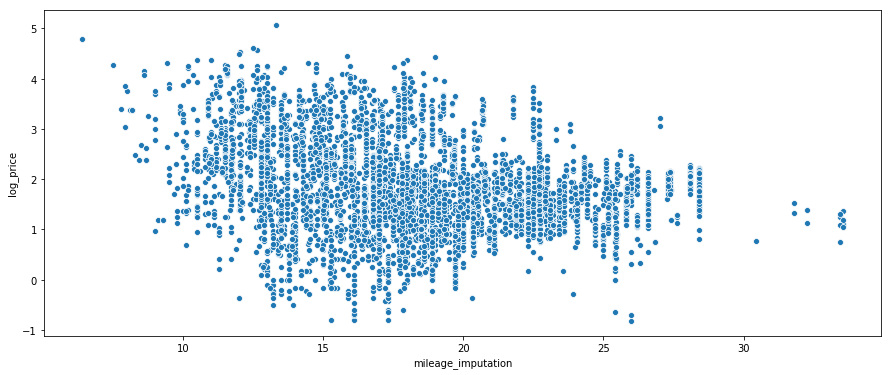

In [106]:
plt.figure(figsize = (15,6))
sns.scatterplot(x = 'mileage_imputation', y = 'log_price', data = df)

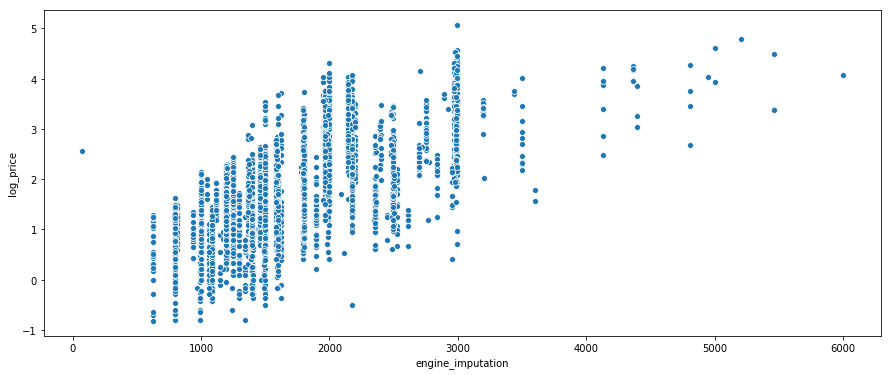

In [49]:
plt.figure(figsize = (15,6))
sns.scatterplot(x = 'engine_imputation', y = 'log_price', data = df)

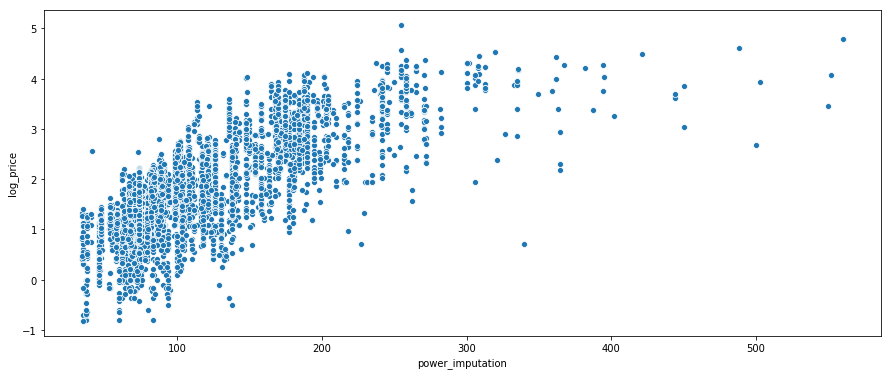

In [41]:
plt.figure(figsize = (15,6))
sns.scatterplot(x = 'power_imputation', y = 'log_price', data = df)

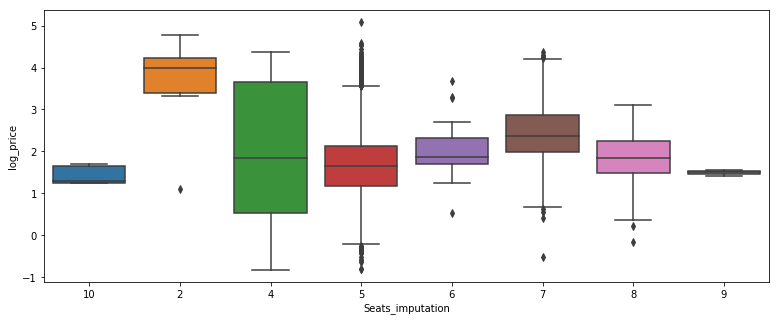

In [208]:
#print("Check Missing Values in Seats Column ",df['Seats'].isnull().sum())
#df['Seats'] = df['Seats'].fillna(0)
#print("Check Now -  Missing Values in Seats Column ",df['Seats'].isnull().sum())

plt.figure(figsize = (13,5))
sns.boxplot(x = 'Seats_imputation', y = 'log_price', data = df) 

In [212]:
print('Check Missing values in any column now --- \n\n\n')
df.isnull().sum()

Check Missing values in any column now --- 





Name                                 0
Location                             0
Year                                 0
Kilometers_Driven                    0
Fuel_Type                            0
Transmission                         0
Owner_Type                           0
Mileage                              0
Engine                               0
Power                                0
Seats                                0
New_Price                         5187
Price                                0
log_price                            0
age                                  0
mileage_amount                       0
engine_amount                        0
power_amount                         0
preprocessed_names                   0
car_brand                            0
car_name2                            0
car_name3                            0
preprocessed_names_num_removed       0
mileage_imputation                   0
engine_imputation                    0
power_imputation         

In [207]:

#with open('df_enhanced.pickle', 'wb') as f:
#    pickle.dump(df, f)




#infile = open('df_enhanced.pickle','rb')
#df = pickle.load(infile)
#infile.close()


# <a id = 'section5'>5. Primary Conclusions and Inferences</a>

##### 1. We have done EDA, some feature extraction, gained an understanding of the Data, performed missing values imputation, removed outliers in some features etc. 

##### 2. We are ready for regression modelling 

##### 3. Model ---- (price ~= f(preprocessed_names (BOW), Location(OHE), age, kms_driven, Fuel(OHE), Transmission(OHE), Owner(OHE), Mileage(imputed), Power(imputed), Engine(imputed), Seats(imputed))

##### 4. Next Sections - (Feature Multicollinearity Checks and Feature Selection, Modelling (Lr. Reg, Reg Tree, RF Tree, GB Tree, XGB Tree, Ensembles)  

##### 5. Our Baseline / Benchmark for prediction is 4.85 (RMSE) and 0.29(RMSLE) since this is the lowest we got so far using just 'preprocessed_names' as the feature (BOW encoding with ngram(1,4)) . Our aim should be to get an RMSE/RMSLE lower than this. 